In [14]:
import json
import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# 1. Import data

In [2]:
# Open the Dataset_training_2019_2023
filename = "Dataset_training_2019_2023.json"

with open(filename, "r") as f:
    Dataset_2019_2023 = json.load(f)

In [10]:
Activity = Dataset_2019_2023['6453042409']
Activity_2 = Dataset_2019_2023['6561999524']

In [73]:
df = pd.DataFrame(Activity)
df.describe()

,temp,watts,velocity_smooth,cadence,distance,altitude,heartrate,time
count,6952.000000,6946.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000,6952.000000
mean,14.147152,287.370141,10.192263,80.625575,35293.757048,453.881559,135.503452,3583.003021
std,1.135888,114.973888,1.964957,12.641058,20912.031625,26.185262,22.780368,2034.476783
min,13.000000,0.000000,0.040000,0.000000,440.800000,385.400000,79.000000,70.000000
25%,13.000000,215.000000,8.881750,78.000000,16152.100000,431.750000,119.000000,1814.750000
50%,14.000000,255.000000,10.007000,85.000000,35677.700000,464.800000,127.000000,3592.500000
75%,15.000000,430.000000,11.446000,88.000000,53475.150000,474.600000,163.000000,5330.250000
max,19.000000,618.000000,15.798000,102.000000,71350.500000,486.200000,180.000000,7146.000000


In [74]:
### Function to calculate the normalized power ###

def cycling_norm_power(Power):

    WindowSize = 30; # second rolling average

    NumberSeries = pd.Series(Power)
    NumberSeries = NumberSeries.dropna()
    Windows      = NumberSeries.rolling(WindowSize)
    Power_30s    = Windows.mean().dropna()

    NP = round((((Power_30s**4).mean())**0.25),0)

    return(NP)

In [75]:
NP=np.nan

power_list = df["watts"]
NP = cycling_norm_power(power_list)
NP

344.0

# 2. Creation of clusters and intervals

In [41]:
def classifier(Activity):
    
    def data_prep (Activity) :
        
        df = pd.DataFrame(Activity)
        df.drop(["date","type","temp","altitude","distance","velocity_smooth","time"],axis=1,inplace=True)
        df_clean = df.fillna(0)
        
        scaler = MinMaxScaler() 
        df_norm = pd.DataFrame(scaler.fit_transform(df_clean),columns = df_clean.columns)
        df_norm["watts"]=df_norm["watts"]*2
        df_norm
        df_norm.plot()
        plt.show()
        return df_norm, df_clean
    
    def knn_find_k (df_norm):
        tab=[]
        
        for i in range(1,10):
            kmeans=KMeans(n_clusters=i, n_init = 10)
            kmeans.fit(df_norm)
            tab.append(kmeans.inertia_)
        print(tab)
        fig = plt.figure()
        plt.plot(data=tab)
        plt.title("La méthode Eblow")
        plt.xlabel("nombre de cluster")
        plt.ylabel("Inertie intra-classe")
        
        return fig
    def knn_set_up (df_norm,df_clean):
        tab=[]

        for i in range(1,10):
            kmeans=KMeans(n_clusters=i, n_init = 10)
            kmeans.fit(df_norm)
            tab.append(kmeans.inertia_)
        plt.plot(range(1,10),tab)
        plt.title("La méthode Eblow")
        plt.xlabel("nombre de cluster")
        plt.ylabel("Inertie intra-classe")
        plt.show()
        
        
        k = int(input('How many cluster do you want ?'))
        kmeans = KMeans(n_clusters=k,max_iter=5000, n_init = 10)
        df_clean["label KNN"] = kmeans.fit_predict(df_norm)
        
        return df_clean
    
    def dbscan_set_up(df_norm,df_clean) :
        
        db = DBSCAN(eps= 0.05, min_samples = 10)
        df_clean["label DBSCAN"] = db.fit_predict(df_norm)
        
        return df_clean
        
    def plot_cluster(df_clean):
        fig, axes = plt.subplots(3, 1, figsize=(20, 12))

        sns.scatterplot(ax=axes[0],data = df_clean, x=df_clean.index, y=df_clean["watts"], hue = df_clean["label KNN"],palette="tab10")
        axes[0].set_title("Power data point labelize")

        sns.scatterplot(ax=axes[1],data = df_clean, x=df_clean.index, y=df_clean["heartrate"], hue = df_clean["label KNN"],palette="tab10")
        axes[1].set_title("Heartrate data point labelize")

        sns.scatterplot(ax=axes[2],data = df_clean, x=df_clean.index, y=df_clean["cadence"], hue = df_clean["label KNN"],palette="tab10")
        axes[2].set_title("Cadence data point labelize");
        
        fig_1, axes_1 = plt.subplots(3, 1, figsize=(20, 12))

        sns.scatterplot(ax=axes_1[0],data = df_clean, x=df_clean.index, y=df_clean["watts"], hue = df_clean["label DBSCAN"],palette="tab10")
        axes_1[0].set_title("Power data point labelize")

        sns.scatterplot(ax=axes_1[1],data = df_clean, x=df_clean.index, y=df_clean["heartrate"], hue = df_clean["label DBSCAN"],palette="tab10")
        axes_1[1].set_title("Heartrate data point labelize")

        sns.scatterplot(ax=axes_1[2],data = df_clean, x=df_clean.index, y=df_clean["cadence"], hue = df_clean["label DBSCAN"],palette="tab10")
        axes_1[2].set_title("Cadence data point labelize");
    
    df_norm, df_clean = data_prep(Activity)
    
    df_clean = knn_set_up (df_norm,df_clean) 
    df_clean = dbscan_set_up(df_norm,df_clean)
    
    plot_cluster(df_clean)

    return df_clean

In [90]:
def create_intervals_resume(df,label_col):
    
    def cycling_norm_power(Power):

        WindowSize = 30; # second rolling average

        NumberSeries = pd.Series(Power)
        NumberSeries = NumberSeries.dropna()
        Windows      = NumberSeries.rolling(WindowSize)
        Power_30s    = Windows.mean().dropna()
        
        NP = round((((Power_30s**4).mean())**0.25),0)
        return(NP)
    
    
    def create_interval(df,label_col) :
        intervals = []
        current_label = None
        interval_start = None
        interval_durations = []
        for idx, row in df.iterrows():
            if current_label is None:
                current_label = row[label_col]
                interval_start = idx
            elif row[label_col] != current_label:
                interval_end = idx - 1
                interval_duration = interval_end - interval_start + 1
                if interval_duration < 15 and intervals:
                    # Merge with the previous interval
                    prev_start, prev_end, previous_label = intervals.pop()
                    intervals.append((prev_start, interval_end,previous_label))  
                else:
                    intervals.append((interval_start, interval_end,current_label))
                current_label = row[label_col]
                interval_start = idx
            else :
                if idx == df.shape[0]-1 :
                    interval_end = idx
                    intervals.append((interval_start, interval_end,current_label))
        return intervals
    
    def merge_interval(intervals) :
        merged_intervals = []
        current_interval = intervals[0]

        for i in range(1, len(intervals)):
            current_label = current_interval[2]
            next_interval = intervals[i]
            if current_label == next_interval[2]:
                # Merge the intervals by taking the minimum of the start values
                # and the maximum of the end values.
                merged_interval = (min(current_interval[0], next_interval[0]), max(current_interval[1], next_interval[1]), current_label)
                current_interval = merged_interval
            else :
                merged_intervals.append(current_interval)
                current_interval = next_interval
                if  i==(len(intervals) - 1):
                    merged_intervals.append(next_interval)  
        return merged_intervals
    
    def create_intervals_duration(merged_intervals) :
        # Append interval duration
        interval_durations = []
        for start_index, end_index, label in merged_intervals:
            diff = end_index - start_index + 1
            interval_durations.append(diff)
        return interval_durations
    
    def create_intervals_metrics(merged_intervals,df) :
        interval_power=[]
        interval_heart = []
        interval_cadence = []
        for start_index, end_index, label in merged_intervals:
            interval_power.append((round(df.iloc[start_index : end_index,0].mean()),max(df.iloc[start_index : end_index,0]),min(df.iloc[start_index : end_index,0])))
            interval_heart.append((round(df.iloc[start_index : end_index,2].mean()),max(df.iloc[start_index : end_index,2]),min(df.iloc[start_index : end_index,2])))
            interval_cadence.append((round(df.iloc[start_index : end_index,1].mean()),max(df.iloc[start_index : end_index,1]),min(df.iloc[start_index : end_index,1])))
        power_resume = pd.DataFrame(interval_power, columns = ["AVG Power","Max Power",'Min Power'])
        heart_resume = pd.DataFrame(interval_heart, columns = ["AVG Heart","Max Heart",'Min Heart'])  
        cadence_resume = pd.DataFrame(interval_cadence, columns =["AVG Cadence","Max Cadence",'Min Cadence'])
                                    
        metrics_resume = pd.concat([power_resume, heart_resume, cadence_resume], axis=1)
                     
        return metrics_resume
    
    def create_data_frame(df) :
        NP=np.nan
        power_list = df["watts"]
        NP = cycling_norm_power(power_list)
        merged_intervals = merge_interval(create_interval(df,label_col))
        interval_durations = create_intervals_duration(merged_intervals)
        metrics_resume = create_intervals_metrics(merged_intervals,df)
        resume_interval = pd.DataFrame(merged_intervals, columns =["Start_time","End_time",'Intervals type'])
        resume_interval["Duration (s)"] = interval_durations
        resume = pd.concat([resume_interval, metrics_resume], axis=1)
        highlighted_rows = (resume['AVG Power'] > NP).map({True: 'background-color: red', False: ''})
        styler = resume.style.apply(lambda _: highlighted_rows)
        
        return resume, styler
    
    return create_data_frame(df)

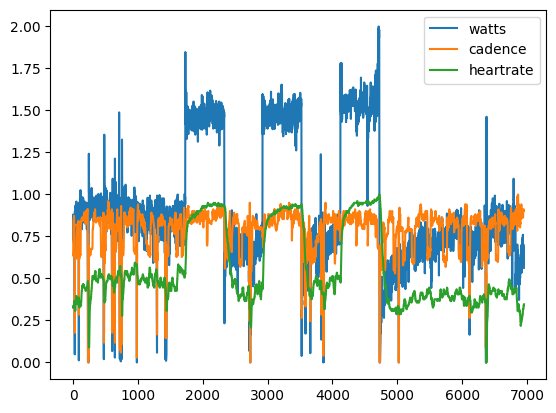

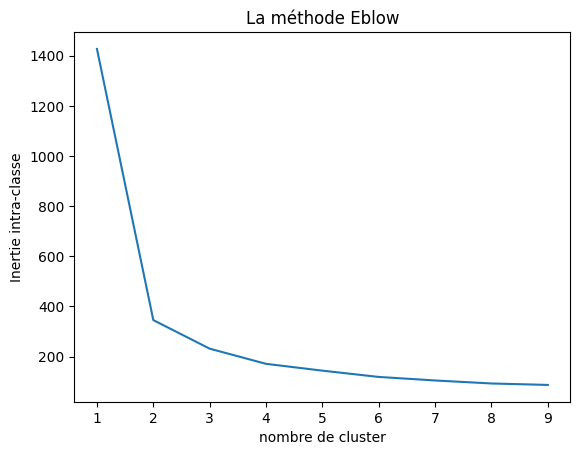

How many cluster do you want ? 2


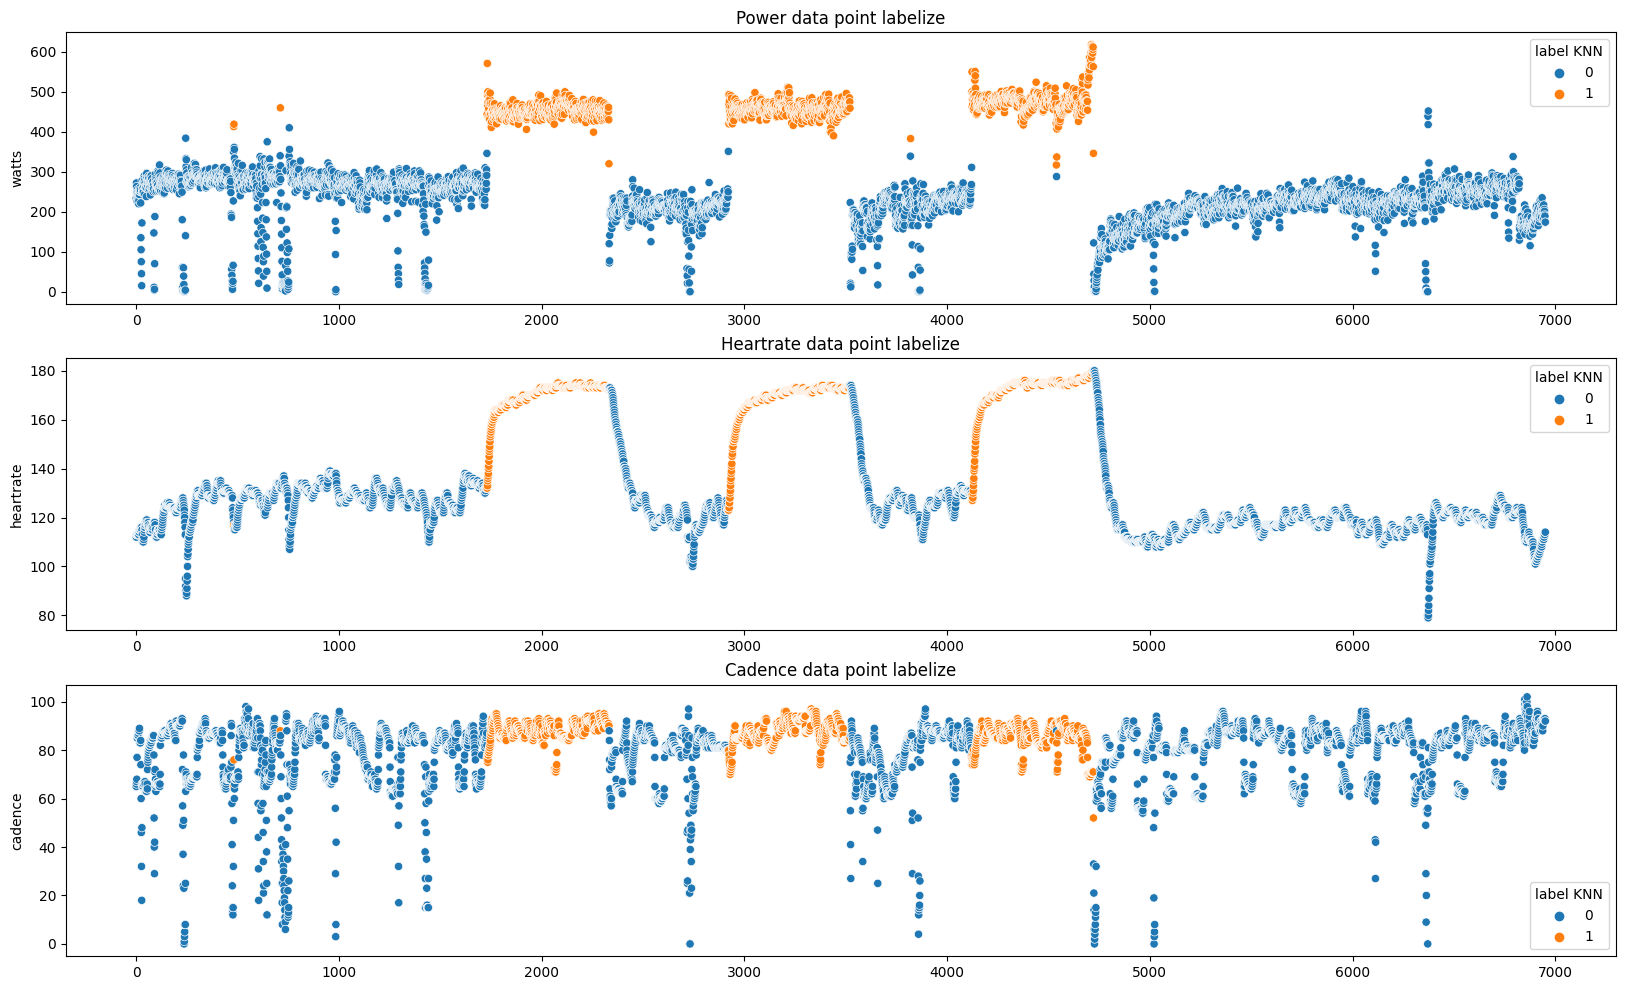

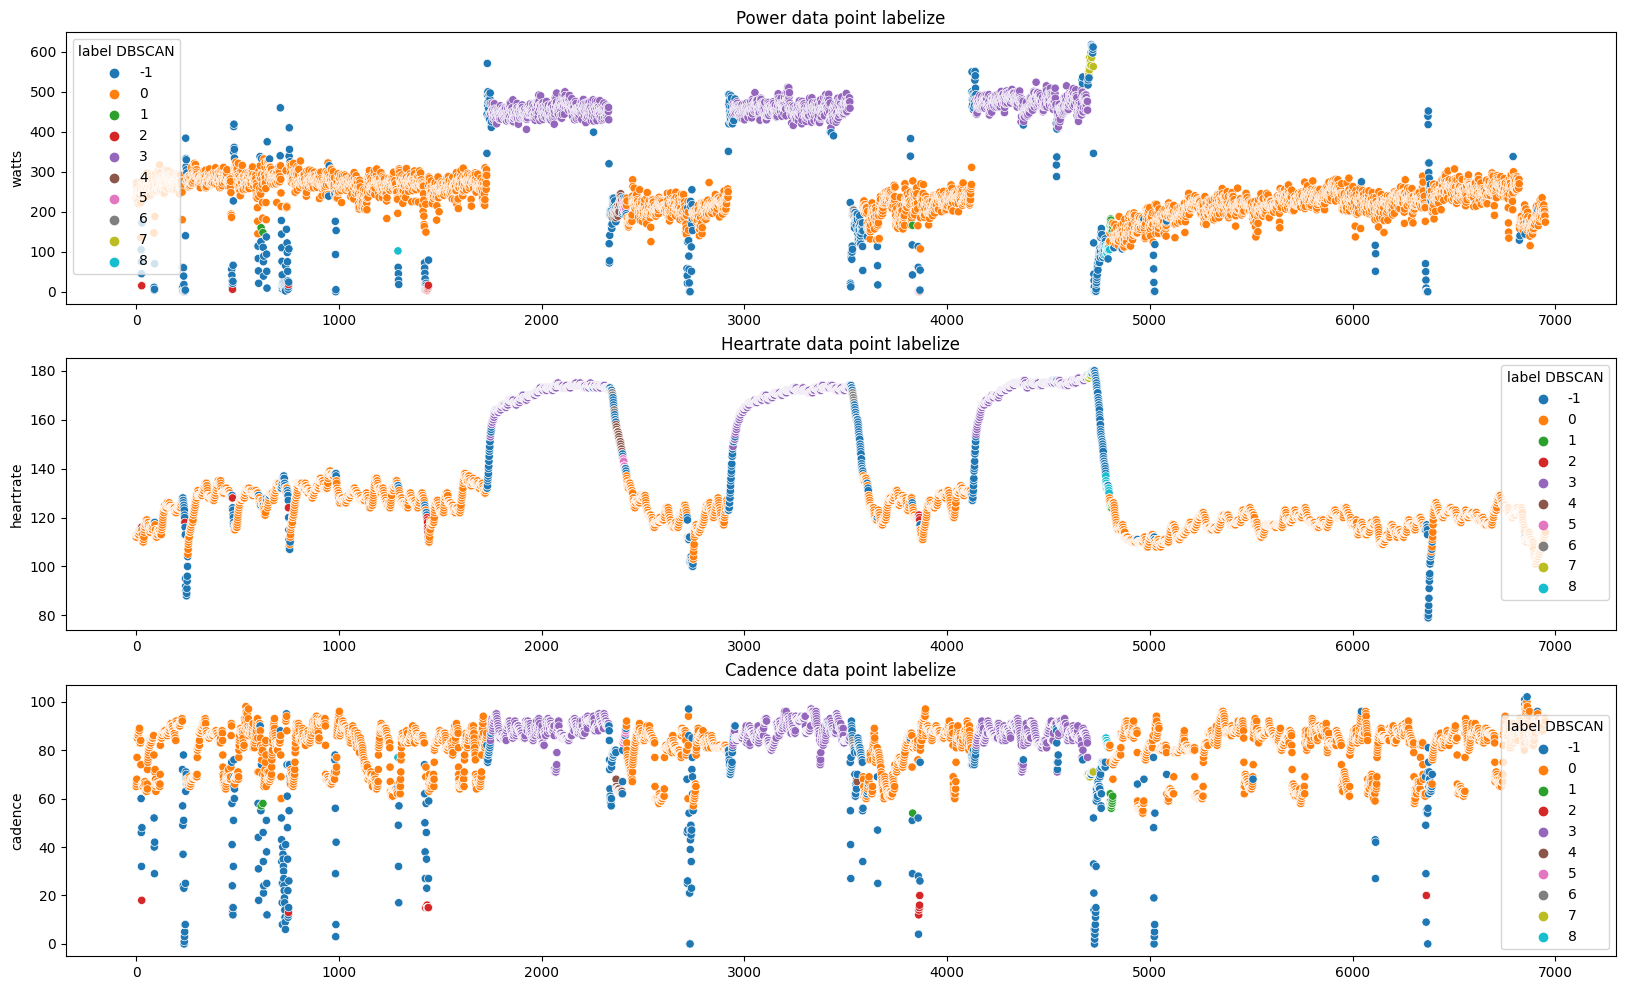

In [79]:
df_clean =  classifier(Activity)

In [91]:
df, styler = create_intervals_resume(df_clean,label_col = "label KNN")
styler

,Start_time,End_time,Intervals type,Duration (s),AVG Power,Max Power,Min Power,AVG Heart,Max Heart,Min Heart,AVG Cadence,Max Cadence,Min Cadence
0,0,1730,0.000000,1731,258,460.000000,0.000000,127,139,88,77,98,0
1,1731,2332,1.000000,602,453,571.000000,399.000000,170,175,132,88,95,71
2,2333,2921,0.000000,589,204,280.000000,0.000000,126,173,100,77,97,0
3,2922,3521,1.000000,600,457,511.000000,390.000000,169,174,123,88,97,70
4,3522,4121,0.000000,600,206,383.000000,0.000000,129,174,111,77,97,4
5,4122,4722,1.000000,601,478,618.000000,288.000000,172,180,127,85,93,69
6,4723,6951,0.000000,2229,212,452.000000,0.000000,118,180,79,80,102,0


In [92]:
df, styler = create_intervals_resume(df_clean, label_col = "label DBSCAN")
styler

,Start_time,End_time,Intervals type,Duration (s),AVG Power,Max Power,Min Power,AVG Heart,Max Heart,Min Heart,AVG Cadence,Max Cadence,Min Cadence
0,0,715,0.000000,716,264,460.000000,0.000000,124,135,88,77,98,0
1,716,759,-1.000000,44,104,410.000000,2.000000,129,137,107,41,95,6
2,760,1729,0.000000,970,260,327.000000,0.000000,129,139,110,79,96,3
3,1730,1753,-1.000000,24,459,571.000000,346.000000,144,157,132,81,89,75
4,1754,2331,3.000000,578,453,500.000000,399.000000,171,175,158,88,95,71
5,2332,2366,-1.000000,35,193,320.000000,72.000000,168,173,159,75,90,57
6,2367,2417,4.000000,51,213,245.000000,185.000000,148,158,139,71,89,62
7,2418,2724,0.000000,307,206,280.000000,21.000000,123,137,111,78,92,25
8,2725,2747,-1.000000,23,131,255.000000,0.000000,104,112,100,48,97,0
9,2748,2920,0.000000,173,209,273.000000,140.000000,120,128,103,81,89,57


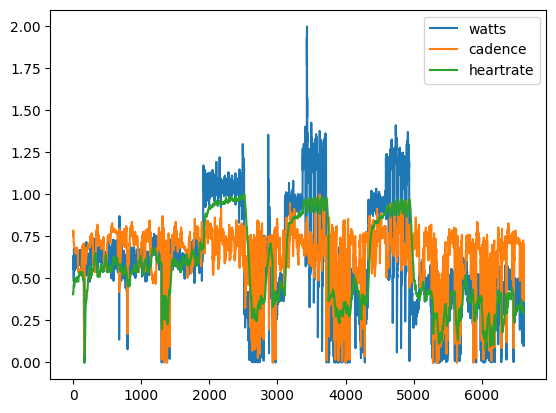

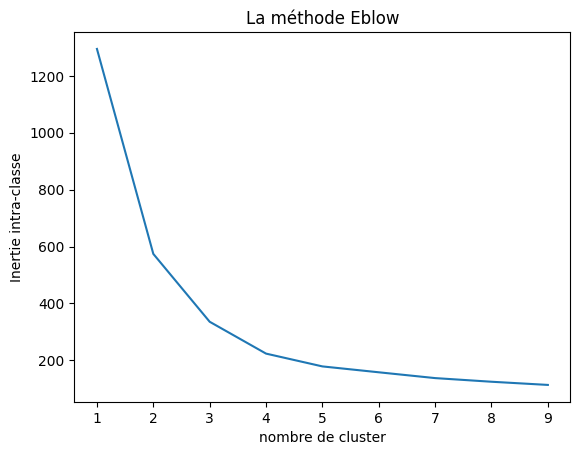

How many cluster do you want ? 3


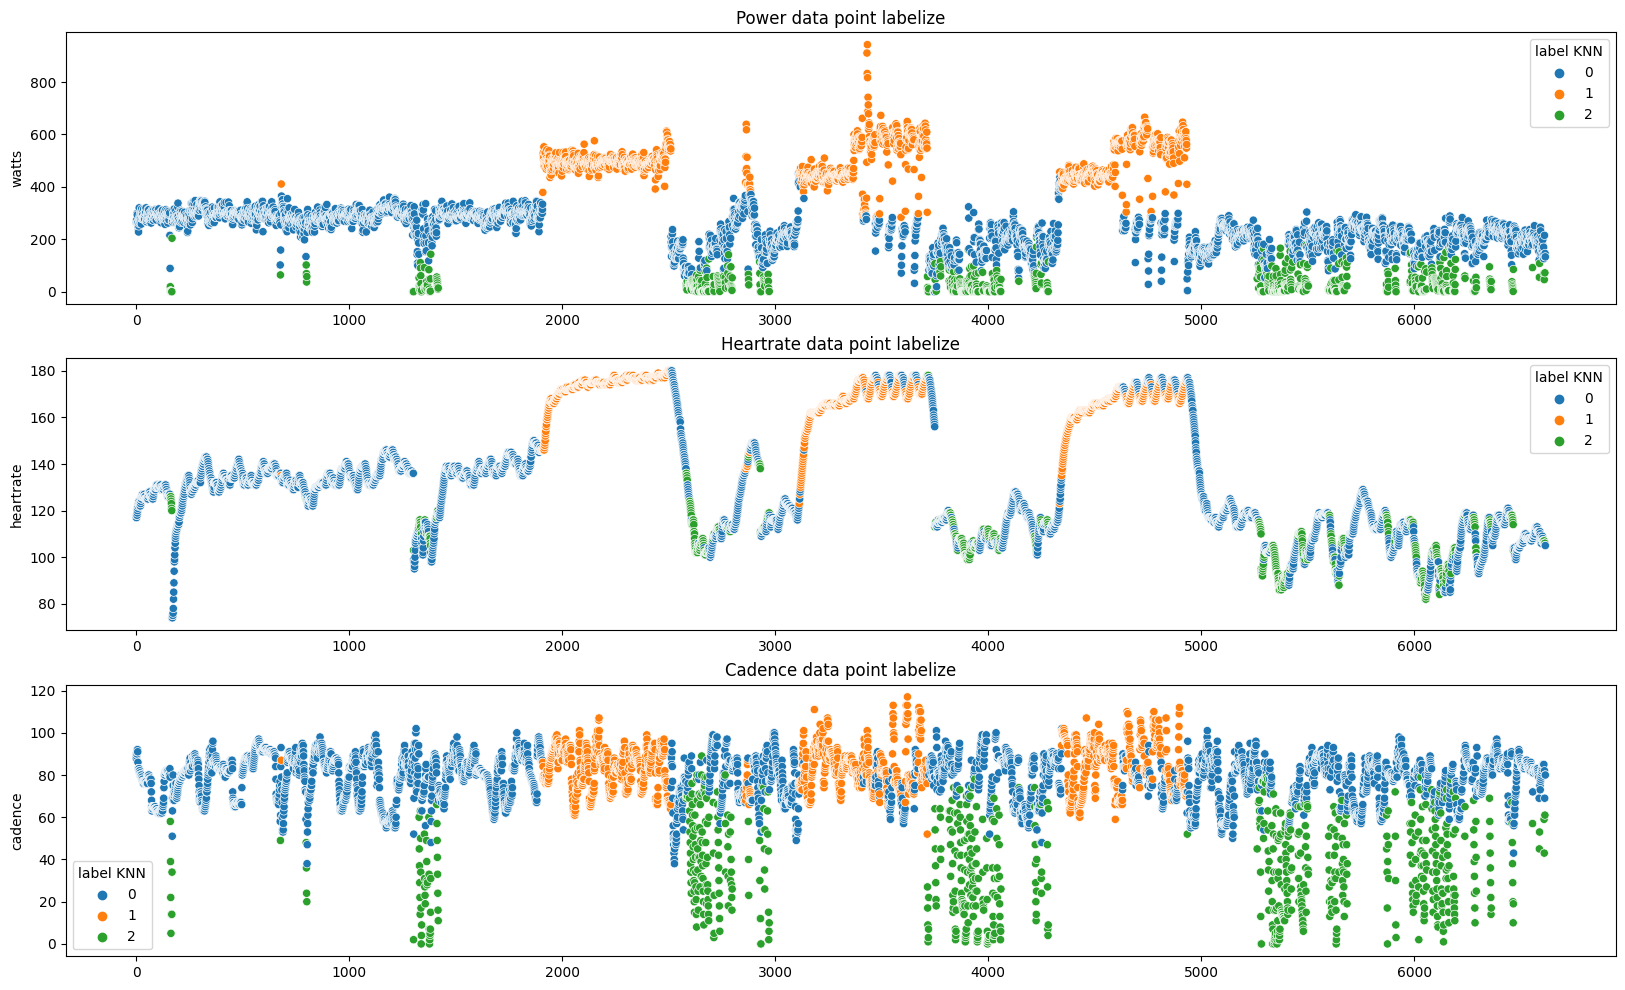

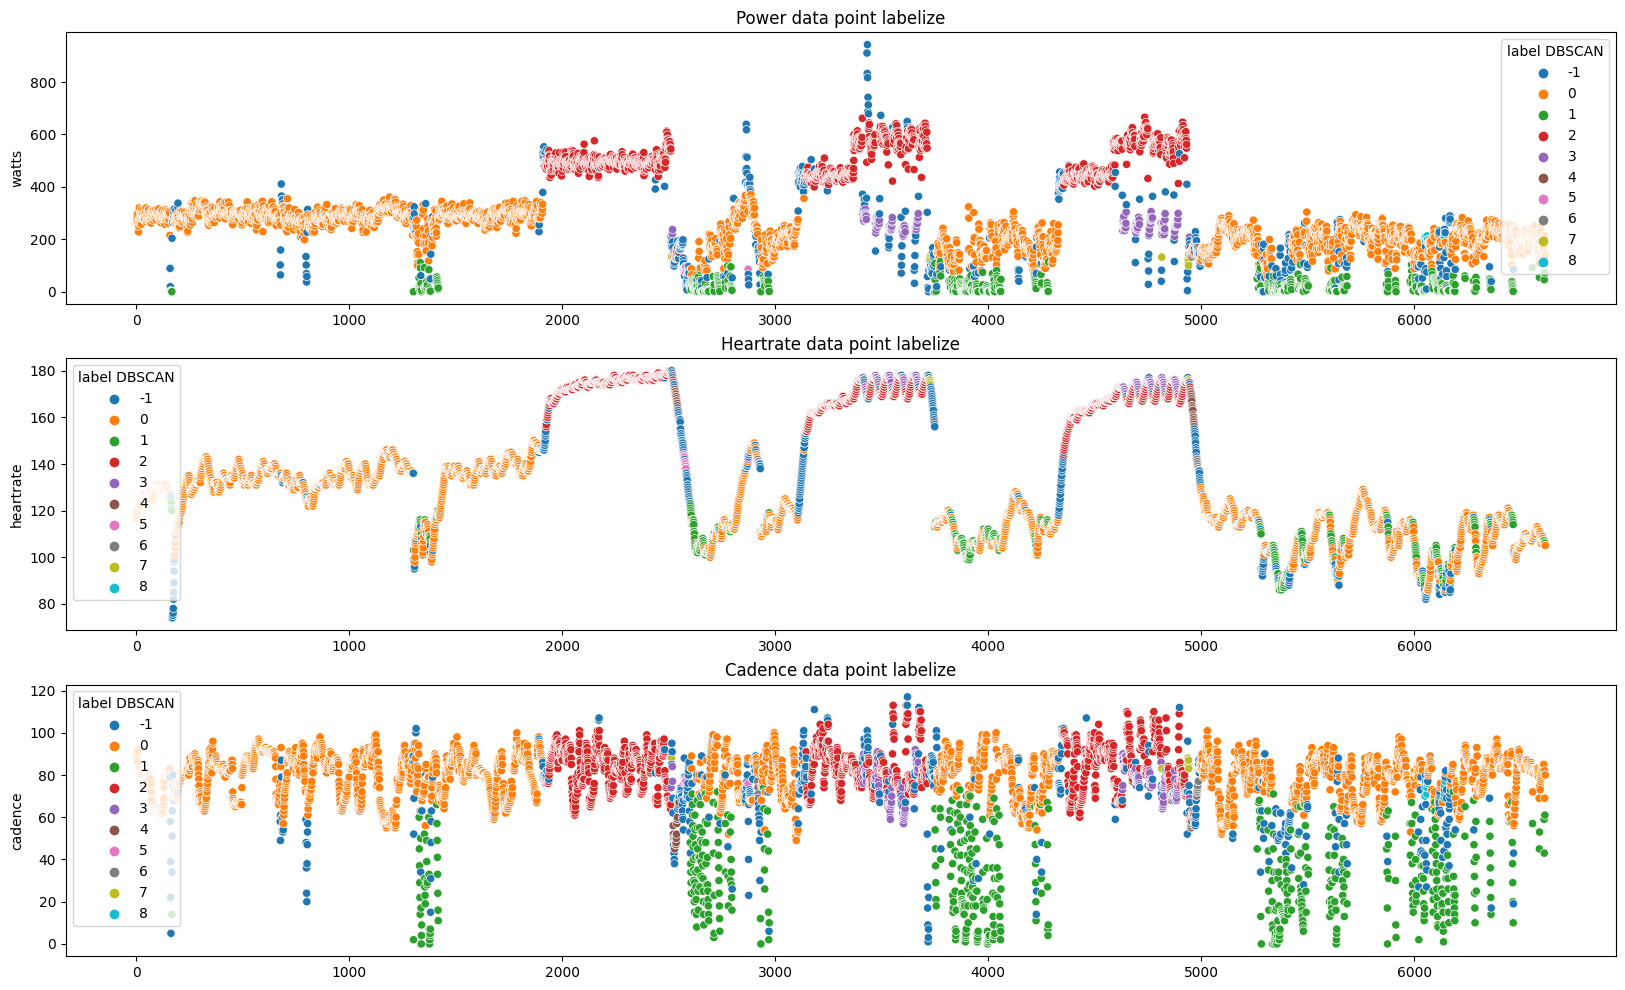

In [93]:
df_clean_2 = classifier(Activity_2)

In [94]:
df, styler = create_intervals_resume(df_clean_2,label_col = "label KNN")
styler

,Start_time,End_time,Intervals type,Duration (s),AVG Power,Max Power,Min Power,AVG Heart,Max Heart,Min Heart,AVG Cadence,Max Cadence,Min Cadence
0,0,1908,0.000000,1909,281,411.000000,0.000000,133,150,74,78,102,0
1,1909,2510,1.000000,602,497,613.000000,379.000000,174,180,146,84,107,61
2,2511,2608,0.000000,98,119,237.000000,7.000000,152,180,116,66,95,24
3,2609,2689,2.000000,81,31,191.000000,1.000000,106,116,101,48,89,8
4,2690,3118,0.000000,429,209,639.000000,0.000000,121,149,100,72,100,0
5,3119,3531,1.000000,413,471,943.000000,155.000000,167,178,130,83,111,66
6,3532,3550,0.000000,19,232,270.000000,168.000000,176,178,172,68,78,59
7,3551,3591,1.000000,41,582,641.000000,422.000000,174,178,169,81,113,71
8,3592,3610,0.000000,19,208,252.000000,71.000000,176,178,172,64,76,57
9,3611,3652,1.000000,42,581,650.000000,307.000000,172,178,168,84,117,67


In [95]:
df, styler = create_intervals_resume(df_clean_2, label_col = "label DBSCAN")
styler

,Start_time,End_time,Intervals type,Duration (s),AVG Power,Max Power,Min Power,AVG Heart,Max Heart,Min Heart,AVG Cadence,Max Cadence,Min Cadence
0,0,1908,0.000000,1909,281,411.000000,0.000000,133,150,74,78,102,0
1,1909,1937,-1.000000,29,498,553.000000,379.000000,154,164,146,78,86,76
2,1938,2549,2.000000,612,475,613.000000,98.000000,175,180,159,82,107,38
3,2550,2609,-1.000000,60,96,198.000000,7.000000,138,159,115,69,89,24
4,2610,2689,1.000000,80,31,191.000000,1.000000,105,116,101,47,89,8
5,2690,3107,0.000000,418,203,639.000000,0.000000,121,149,100,72,100,0
6,3108,3147,-1.000000,40,433,478.000000,308.000000,138,154,119,81,101,57
7,3148,3471,2.000000,324,473,943.000000,260.000000,167,177,154,84,111,66
8,3472,3496,3.000000,25,328,630.000000,224.000000,174,178,170,81,91,67
9,3497,3535,2.000000,39,554,631.000000,168.000000,174,178,169,79,87,65
